# ライブラリ読み込み

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

# utility
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import glob
import os
import sys
from sys import stderr

# 乱数
rng = np.random.RandomState(1234)
random_state = 42

# pytorch
# conda install pytorch torchvision -c pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# 囲碁ライブラリ
from sgfmill import sgf
from sgfmill import boards

# ルートに移動
%cd /Users/keimy/git/humanized-models-for-board-games/igo
%pwd


/Users/keimy/git/humanized-models-for-board-games/igo


'/Users/keimy/git/humanized-models-for-board-games/igo'

# Visualize Data

In [2]:
# .npy ファイルからデータをロード
move_tensors = np.load('./preprocess/tensors_at_move.npy')

move_tensors.shape

(55191, 2, 19, 19)

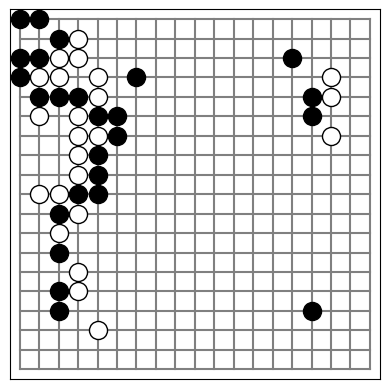

0

In [3]:
from src.board import visualize_matrix

black_matrix, white_matrix = move_tensors[200]
visualize_matrix(black_matrix, white_matrix)


# Make Dataloaders

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

# トレーニングセットと検証セットに分割
train_size = int(0.8 * len(move_tensors))
valid_size = len(move_tensors) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(move_tensors, [train_size, valid_size])

# データローダーの設定
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [5]:
for x in train_loader:
    print(x.shape)
    # print(x)
    break

len(train_loader)

torch.Size([128, 2, 19, 19])


345

# VAE-linear

In [6]:
from src.model.VAE_linear import VAE_linear
z_dim = 10
assert z_dim >= 2
input_dim =  2 * 19 * 19
n_epochs = 3

device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"

model = VAE_linear(z_dim = z_dim, input_dim = input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for x in train_loader:
        x = x.float().to(device)  # データ型をfloatに変換してからデバイスに送る

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in valid_loader:
        x = x.float().to(device)  # ここでも同様にデータ型をfloatに変換

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


EPOCH: 1    Train Lower Bound: 0.656527 (KL_loss: 0.024522. reconstruction_loss: 0.632005)    Valid Lower Bound: 0.601056
EPOCH: 2    Train Lower Bound: 0.600269 (KL_loss: 0.000803. reconstruction_loss: 0.599466)    Valid Lower Bound: 0.600499
EPOCH: 3    Train Lower Bound: 0.599755 (KL_loss: 0.000452. reconstruction_loss: 0.599302)    Valid Lower Bound: 0.600339


任意のxをもとに可視化

xはバッチで投げればy,zもバッチで返ってくる


xを単体で投げた場合はバッチサイズ=1と解釈されて

y,zもバッチサイズ=1の次元になるのでスクイーズが必要

In [8]:
model.eval()

for x in valid_loader:
    print(x.shape, x.dtype)
    x = x.float().to(device)

    # xはバッチで投げている
    y, z = model(x)
    y = y.cpu().detach().numpy()

    print(y.shape, z.shape)
    break


torch.Size([128, 2, 19, 19]) torch.int64
(128, 2, 19, 19) torch.Size([128, 10])


xを単体で投げる

In [9]:
model.eval()

i = 40
x = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.to(device)

# x単体を投げる
y, z = model(x)
y = y.cpu().detach().numpy()


x.shape, y.shape, z.shape

(torch.Size([2, 19, 19]), (1, 2, 19, 19), torch.Size([1, 10]))

tensor([[-4.8449e-03,  1.3127e-03,  6.5393e-04,  1.5779e-03, -3.8530e-04,
         -2.1007e-04,  1.0417e-03, -3.3249e-03, -1.5075e-03,  4.4003e-05]],
       device='mps:0', grad_fn=<LinearBackward0>)
reconstructed move


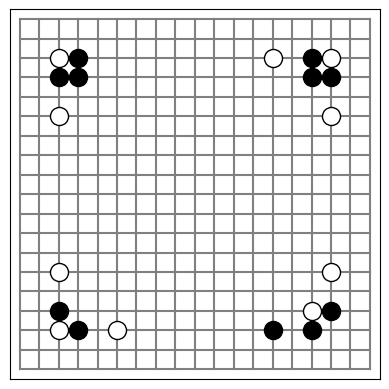

original move


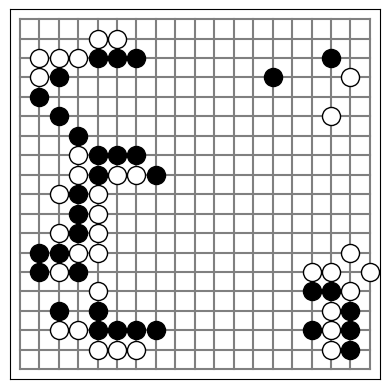

0

In [20]:
model.eval()

i = 40
x = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.to(device)

y, z = model(x)
y = y.cpu().detach().numpy()

# yの閾値処理
th = 0.24
y[y >= th] = 1
y[y < th] = 0

print(z)

print("reconstructed move")
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)

print("original move")
black_matrix, white_matrix = x.squeeze()
visualize_matrix(black_matrix, white_matrix)

Zのランダムサンプリング

tensor([[ 1.3901,  0.9664,  0.6489, -0.0276,  0.5585, -0.3675, -0.0820, -1.1894,
          0.4822, -0.2495]], device='mps:0')


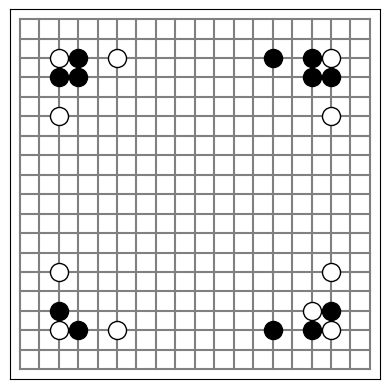

0

In [139]:
z = torch.randn([1, z_dim]).to(device)

model.eval()
y = model._decoder(z)
y = y.cpu().detach().numpy()

# yの閾値処理
th = 0.24
y[y >= th] = 1
y[y < th] = 0

print(z)
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)

# VAE-CNN

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Tuple

rng = np.random.RandomState(1234)
random_state = 42
device = "mps" if torch.backends.mps.is_available() else "cpu"

# input_dim = 2*19*19


class CNNEncoder(nn.Module):
    """ CNNベースのエンコーダ """
    def __init__(self, z_dim, h_dim):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 19 * 19, h_dim)
        self.fc_mean = nn.Linear(h_dim, z_dim)
        self.fc_var = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        return mean, log_var


class CNNDecoder(nn.Module):
    """ CNNベースのデコーダ """
    def __init__(self, z_dim, h_dim):
        super(CNNDecoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 32 * 19 * 19)
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        # z.size(0)はバッチサイズ
        z = z.view(z.size(0), 32, 19, 19)
        z = F.relu(self.deconv1(z))
        reconstruction = torch.sigmoid(self.deconv2(z))
        return reconstruction


class VAE_CNN(nn.Module):
    """ CNNベースのVAE """
    def __init__(self, z_dim=64, h_dim=128):
        super(VAE_CNN, self).__init__()
        self.encoder = CNNEncoder(z_dim, h_dim)
        self.decoder = CNNDecoder(z_dim, h_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var
    

    def loss(self, x):
        # モデルのforwardパスを使用して、再構成されたデータ、平均、対数分散を取得
        recon_x, mean, log_var = self.forward(x)

        # 再構成誤差（バイナリクロスエントロピー）
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

        # KLダイバージェンス
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

        return KLD, BCE  # KLダイバージェンスと再構成誤差を返す


In [141]:
# from src.model.VAE_CNN import VAE_CNN

z_dim = 64
assert z_dim >= 2
input_dim =  2 * 19 * 19
n_epochs = 5

device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"

model = VAE_CNN(z_dim = z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for x in train_loader:
        x = x.float().to(device)  # データ型をfloatに変換してからデバイスに送る

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in valid_loader:
        x = x.float().to(device)  # ここでも同様にデータ型をfloatに変換

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


EPOCH: 1    Train Lower Bound: 28827.716797 (KL_loss: 13.602427. reconstruction_loss: 28814.113281)    Valid Lower Bound: 27591.615234
EPOCH: 2    Train Lower Bound: 27776.060547 (KL_loss: 0.929126. reconstruction_loss: 27775.130859)    Valid Lower Bound: 27529.468750
EPOCH: 3    Train Lower Bound: 27735.878906 (KL_loss: 0.339861. reconstruction_loss: 27735.537109)    Valid Lower Bound: 27509.939453
EPOCH: 4    Train Lower Bound: 27708.298828 (KL_loss: 0.237323. reconstruction_loss: 27708.064453)    Valid Lower Bound: 27477.462891
EPOCH: 5    Train Lower Bound: 27691.419922 (KL_loss: 0.172380. reconstruction_loss: 27691.246094)    Valid Lower Bound: 27491.699219


再構成moveを可視化

reconstructed move


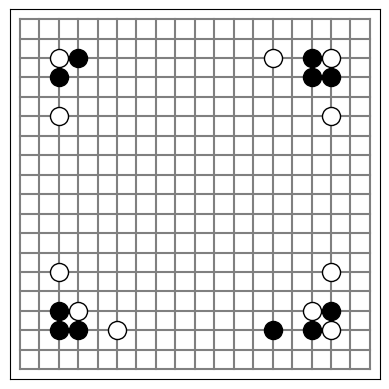

original move


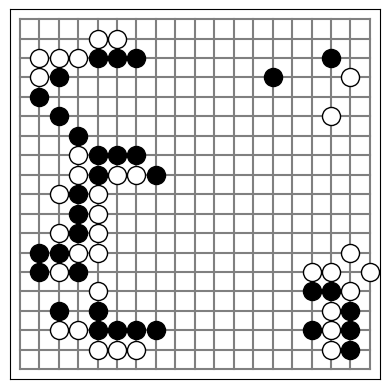

0

In [160]:
model.eval()

i = 40
x = valid_dataset[i]
x = torch.from_numpy(x).float()
x = x.unsqueeze(0)
x = x.to(device)

y, z_mu, z_var = model(x)
y = y.cpu().detach().numpy()

# # yの閾値処理
th = 0.24
y[y >= th] = 1
y[y < th] = 0


print("reconstructed move")
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)

print("original move")
black_matrix, white_matrix = x.squeeze()
visualize_matrix(black_matrix, white_matrix)

Zをランダムサンプリング

z_dim: 64


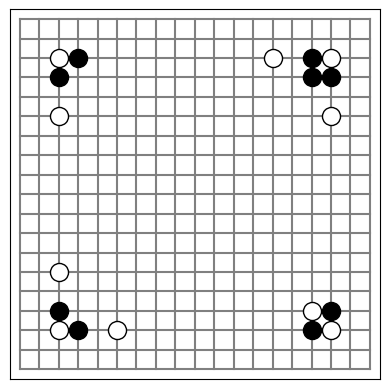

0

In [231]:
# ランダムな潜在変数 z をサンプリング
# ここでの z_dim は、モデルで使用されている潜在空間の次元数
z = torch.randn(1, z_dim).to(device)

# 学習済みのモデルの decoder 部分を使用して z を再構成
with torch.no_grad():  # 勾配計算を行わない
    model.eval()
    y = model.decoder(z)

y = y.cpu().detach().numpy()


# yの閾値処理
th = 0.26
y[y >= th] = 1
y[y < th] = 0

print("z_dim:", z_dim)
# print(z)
black_matrix, white_matrix = y.squeeze()
visualize_matrix(black_matrix, white_matrix)
